In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

### No extra weight on buy/sell

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# load data and preprocess
df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_7']) # no label_7 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# features / target
X = df.drop(columns=['label_3']).values
y = LabelEncoder().fit_transform(df['label_3'])

# scale numerics
X = StandardScaler().fit_transform(X)

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

# the actual model
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    # training
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           StandardScaler().fit(df.drop(columns=['label_3'])),
    'label_encoder':    LabelEncoder().fit(df['label_3']),
    'stock_encoder':    LabelEncoder().fit(df['stock_id'])
}, "stock_label3_model.pth")


Epoch 1/10 — Train Loss: 0.7041 — Val Acc: 0.7546
Epoch 2/10 — Train Loss: 0.6882 — Val Acc: 0.7554
Epoch 3/10 — Train Loss: 0.6823 — Val Acc: 0.7563
Epoch 4/10 — Train Loss: 0.6772 — Val Acc: 0.7587
Epoch 5/10 — Train Loss: 0.6715 — Val Acc: 0.7585
Epoch 6/10 — Train Loss: 0.6653 — Val Acc: 0.7596
Epoch 7/10 — Train Loss: 0.6587 — Val Acc: 0.7618
Epoch 8/10 — Train Loss: 0.6517 — Val Acc: 0.7623
Epoch 9/10 — Train Loss: 0.6453 — Val Acc: 0.7639
Epoch 10/10 — Train Loss: 0.6383 — Val Acc: 0.7659


In [4]:
# get the input features (same preprocessing as before)
X_all = df.drop(columns=['label_3']).values
X_all = StandardScaler().fit_transform(X_all)  # ideally use the same scaler object

X_all_tensor = torch.from_numpy(X_all).float().to(device)

# predict
model.eval()
with torch.no_grad():
    logits = model(X_all_tensor)
    preds = logits.argmax(dim=1).cpu().numpy()
    label_names = LabelEncoder().fit(df['label_3']).inverse_transform(preds)  # ideally use the same encoder

# attach predictions to original df
df_result = df.copy()
df_result['predicted_label_3'] = label_names


In [7]:
df_result.to_csv("predicted_trainset_labels.csv", index=False)

In [8]:
df = pd.read_csv("testing_data.csv")
df = df.drop(columns=['date', 'title', 'label_7']) # no label_7 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
# get the input features (same preprocessing as before)
X_all = df.drop(columns=['label_3']).values
X_all = StandardScaler().fit_transform(X_all)  # ideally use the same scaler object

X_all_tensor = torch.from_numpy(X_all).float().to(device)

# predict
model.eval()
with torch.no_grad():
    logits = model(X_all_tensor)
    preds = logits.argmax(dim=1).cpu().numpy()
    label_names = LabelEncoder().fit(df['label_3']).inverse_transform(preds)  # ideally use the same encoder

# attach predictions to original df
df_result = df.copy()
df_result['predicted_label_3'] = label_names
df_result.to_csv("predicted_testset_labels.csv", index=False)

In [9]:
df = pd.read_csv("validation_data.csv")
df = df.drop(columns=['date', 'title', 'label_7']) # no label_7 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
# get the input features (same preprocessing as before)
X_all = df.drop(columns=['label_3']).values
X_all = StandardScaler().fit_transform(X_all)  # ideally use the same scaler object

X_all_tensor = torch.from_numpy(X_all).float().to(device)

# predict
model.eval()
with torch.no_grad():
    logits = model(X_all_tensor)
    preds = logits.argmax(dim=1).cpu().numpy()
    label_names = LabelEncoder().fit(df['label_3']).inverse_transform(preds)  # ideally use the same encoder

# attach predictions to original df
df_result = df.copy()
df_result['predicted_label_3'] = label_names
df_result.to_csv("predicted_validation_labels.csv", index=False)

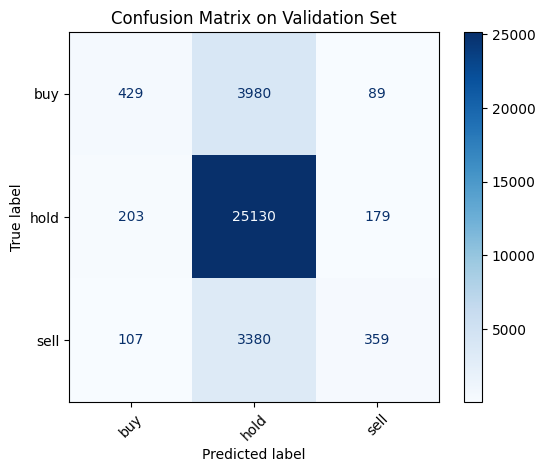

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buy', 'hold', 'sell'])

import matplotlib.pyplot as plt
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_3'])  # different label here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=['label_7']).values
y = LabelEncoder().fit_transform(df['label_7'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

# no changes to the model
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           scaler,
    'label_encoder_7':  LabelEncoder().fit(df['label_7']),
    'stock_encoder':    LabelEncoder().fit(df['stock_id'])
}, "stock_label7_model.pth")


Epoch 1/10 — Train Loss: 0.8401 — Val Acc: 0.6688
Epoch 2/10 — Train Loss: 0.8266 — Val Acc: 0.6694
Epoch 3/10 — Train Loss: 0.8213 — Val Acc: 0.6681
Epoch 4/10 — Train Loss: 0.8152 — Val Acc: 0.6715
Epoch 5/10 — Train Loss: 0.8087 — Val Acc: 0.6760
Epoch 6/10 — Train Loss: 0.8015 — Val Acc: 0.6746
Epoch 7/10 — Train Loss: 0.7944 — Val Acc: 0.6786
Epoch 8/10 — Train Loss: 0.7865 — Val Acc: 0.6803
Epoch 9/10 — Train Loss: 0.7785 — Val Acc: 0.6831
Epoch 10/10 — Train Loss: 0.7702 — Val Acc: 0.6854


In [ ]:
# Make sure model is in eval mode
model.eval()

# Grab original features and scale with the same scaler
X_all = df.drop(columns=['label_7']).values
X_all_scaled = scaler.transform(X_all)
X_all_tensor = torch.from_numpy(X_all_scaled).float().to(device)

# Predict
with torch.no_grad():
    logits = model(X_all_tensor)
    pred_indices = logits.argmax(dim=1).cpu().numpy()
    pred_labels = LabelEncoder().fit(df['label_7']).inverse_transform(pred_indices)  # ideally reuse the encoder
df_result = df.copy()
df_result['predicted_label_7'] = label_names
df_result.to_csv("predicted_test_labels.csv", index=False)

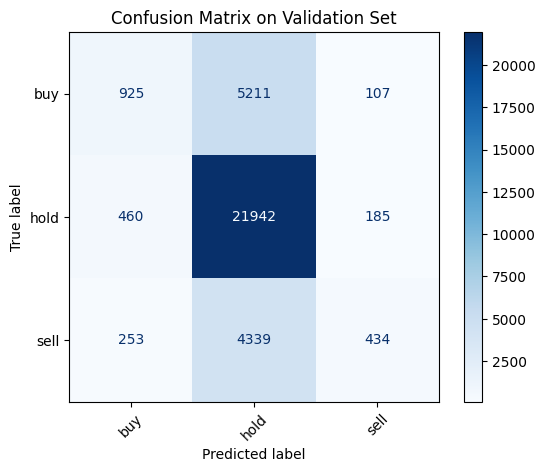

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buy', 'hold', 'sell'])

import matplotlib.pyplot as plt
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()


As we can see hold takes a heavy preference.

In [10]:
df = pd.read_csv("training_data.csv")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [15]:
df['label_3'].value_counts(), df['label_7'].value_counts()

(label_3
 hold    85037
 buy     14993
 sell    12821
 Name: count, dtype: int64,
 label_7
 hold    75290
 buy     20808
 sell    16753
 Name: count, dtype: int64)

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_3'])
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=['label_7']).values
y = LabelEncoder().fit_transform(df['label_7'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# change weights
counts = Counter(y_train)
total  = len(y_train)
num_classes = len(counts)
weights = [ total/(num_classes * counts[i]) for i in range(num_classes) ]
class_weights = torch.tensor(weights, dtype=torch.float32)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)


class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

# move weights onto the same device as model, if using GPU
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           scaler,
    'label_encoder_7':  LabelEncoder().fit(df['label_7']),
    'stock_encoder':    LabelEncoder().fit(df['stock_id'])
}, "stock_label7_model.pth")


Epoch 1/10 — Train Loss: 1.0690 — Val Acc: 0.4934
Epoch 2/10 — Train Loss: 1.0572 — Val Acc: 0.5292
Epoch 3/10 — Train Loss: 1.0495 — Val Acc: 0.5537
Epoch 4/10 — Train Loss: 1.0410 — Val Acc: 0.4892
Epoch 5/10 — Train Loss: 1.0308 — Val Acc: 0.5357
Epoch 6/10 — Train Loss: 1.0205 — Val Acc: 0.5484
Epoch 7/10 — Train Loss: 1.0079 — Val Acc: 0.5426
Epoch 8/10 — Train Loss: 0.9956 — Val Acc: 0.5085
Epoch 9/10 — Train Loss: 0.9824 — Val Acc: 0.5380
Epoch 10/10 — Train Loss: 0.9681 — Val Acc: 0.5428


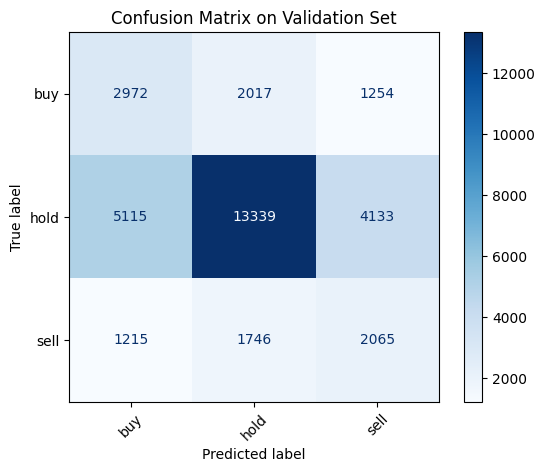

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buy', 'hold', 'sell'])

import matplotlib.pyplot as plt
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_7'])
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=['label_3']).values
y = LabelEncoder().fit_transform(df['label_3'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# same addition as before
counts = Counter(y_train)
total  = len(y_train)
num_classes = len(counts)
weights = [ total/(num_classes * counts[i]) for i in range(num_classes) ]
class_weights = torch.tensor(weights, dtype=torch.float32)
# move to GPU if available later


class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           scaler,
    'label_encoder_3':  LabelEncoder().fit(df['label_3']),
    'stock_encoder':    LabelEncoder().fit(df['stock_id'])
}, "stock_label3_model.pth")


Epoch 1/10 — Train Loss: 1.0600 — Val Acc: 0.5211
Epoch 2/10 — Train Loss: 1.0461 — Val Acc: 0.5325
Epoch 3/10 — Train Loss: 1.0355 — Val Acc: 0.5111
Epoch 4/10 — Train Loss: 1.0241 — Val Acc: 0.5670
Epoch 5/10 — Train Loss: 1.0123 — Val Acc: 0.5258
Epoch 6/10 — Train Loss: 0.9996 — Val Acc: 0.5623
Epoch 7/10 — Train Loss: 0.9856 — Val Acc: 0.5307
Epoch 8/10 — Train Loss: 0.9727 — Val Acc: 0.5057
Epoch 9/10 — Train Loss: 0.9574 — Val Acc: 0.5459
Epoch 10/10 — Train Loss: 0.9426 — Val Acc: 0.5538


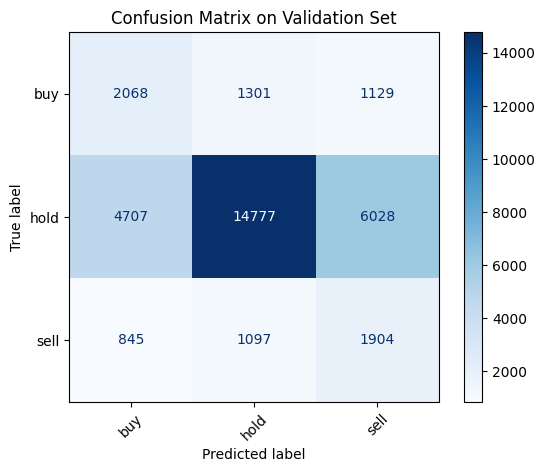

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for Xb, yb in val_loader:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buy', 'hold', 'sell'])

import matplotlib.pyplot as plt
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample

"""Random Sampling for Equal Amounts of Buy/Hold/Sell"""
# load data and preprocess
df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_7']) # no label_7 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

buy_df = df[df['label_3'] == 'buy']
hold_df = df[df['label_3'] == 'hold']
sell_df = df[df['label_3'] == 'sell']

min_size = min(len(buy_df), len(hold_df), len(sell_df))

buy_bal = resample(buy_df, replace=False, n_samples=min_size, random_state=42)
hold_bal = resample(hold_df, replace=False, n_samples=min_size, random_state=42)
sell_bal = resample(sell_df, replace=False, n_samples=min_size, random_state=42)

train_df = pd.concat([buy_bal, hold_bal, sell_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

X = train_df.drop(columns=['label_3']).values
y = LabelEncoder().fit_transform(train_df['label_3'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

# the actual model
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    # training
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           StandardScaler().fit(train_df.drop(columns=['label_3'])),
    'label_encoder':    LabelEncoder().fit(train_df['label_3']),
    'stock_encoder':    LabelEncoder().fit(train_df['stock_id'])
}, "stock_label3_model.pth")



Epoch 1/10 — Train Loss: 1.0671 — Val Acc: 0.4179
Epoch 2/10 — Train Loss: 1.0511 — Val Acc: 0.4407
Epoch 3/10 — Train Loss: 1.0425 — Val Acc: 0.4341
Epoch 4/10 — Train Loss: 1.0352 — Val Acc: 0.4449
Epoch 5/10 — Train Loss: 1.0265 — Val Acc: 0.4520
Epoch 6/10 — Train Loss: 1.0183 — Val Acc: 0.4591
Epoch 7/10 — Train Loss: 1.0079 — Val Acc: 0.4639
Epoch 8/10 — Train Loss: 0.9993 — Val Acc: 0.4709
Epoch 9/10 — Train Loss: 0.9900 — Val Acc: 0.4824
Epoch 10/10 — Train Loss: 0.9788 — Val Acc: 0.4806


In [12]:
"""Random Sampling for Equal Amounts of Buy/Hold/Sell for label 7"""
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample

# load data and preprocess
df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_3']) # no label_3 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

buy_df = df[df['label_7'] == 'buy']
hold_df = df[df['label_7'] == 'hold']
sell_df = df[df['label_7'] == 'sell']

min_size = min(len(buy_df), len(hold_df), len(sell_df))

buy_bal = resample(buy_df, replace=False, n_samples=min_size, random_state=42)
hold_bal = resample(hold_df, replace=False, n_samples=min_size, random_state=42)
sell_bal = resample(sell_df, replace=False, n_samples=min_size, random_state=42)

train_df = pd.concat([buy_bal, hold_bal, sell_bal]).sample(frac=1, random_state=42).reset_index(drop=True)

X = train_df.drop(columns=['label_7']).values
y = LabelEncoder().fit_transform(train_df['label_7'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

# the actual model
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    # training
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           StandardScaler().fit(train_df.drop(columns=['label_7'])),
    'label_encoder':    LabelEncoder().fit(train_df['label_7']),
    'stock_encoder':    LabelEncoder().fit(train_df['stock_id'])
}, "stock_label7_model.pth")



Epoch 1/10 — Train Loss: 1.0748 — Val Acc: 0.4221
Epoch 2/10 — Train Loss: 1.0613 — Val Acc: 0.4272
Epoch 3/10 — Train Loss: 1.0545 — Val Acc: 0.4422
Epoch 4/10 — Train Loss: 1.0475 — Val Acc: 0.4354
Epoch 5/10 — Train Loss: 1.0412 — Val Acc: 0.4477
Epoch 6/10 — Train Loss: 1.0348 — Val Acc: 0.4377
Epoch 7/10 — Train Loss: 1.0269 — Val Acc: 0.4605
Epoch 8/10 — Train Loss: 1.0172 — Val Acc: 0.4565
Epoch 9/10 — Train Loss: 1.0101 — Val Acc: 0.4674
Epoch 10/10 — Train Loss: 0.9994 — Val Acc: 0.4635


In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample

"""Dropping sentiment column for label_3"""
# load data and preprocess
df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_7']) # no label_7 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock','sentiment'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=['label_3']).values
y = LabelEncoder().fit_transform(df['label_3'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

# the actual model
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    # training
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           StandardScaler().fit(df.drop(columns=['label_3'])),
    'label_encoder':    LabelEncoder().fit(df['label_3']),
    'stock_encoder':    LabelEncoder().fit(df['stock_id'])
}, "stock_label3_model.pth")



Epoch 1/10 — Train Loss: 0.7021 — Val Acc: 0.7541
Epoch 2/10 — Train Loss: 0.6878 — Val Acc: 0.7554
Epoch 3/10 — Train Loss: 0.6818 — Val Acc: 0.7562
Epoch 4/10 — Train Loss: 0.6754 — Val Acc: 0.7577
Epoch 5/10 — Train Loss: 0.6688 — Val Acc: 0.7593
Epoch 6/10 — Train Loss: 0.6611 — Val Acc: 0.7593
Epoch 7/10 — Train Loss: 0.6530 — Val Acc: 0.7612
Epoch 8/10 — Train Loss: 0.6451 — Val Acc: 0.7653
Epoch 9/10 — Train Loss: 0.6367 — Val Acc: 0.7659
Epoch 10/10 — Train Loss: 0.6295 — Val Acc: 0.7691


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample

"""Dropping sentiment column for label_7"""
# load data and preprocess
df = pd.read_csv("training_data.csv")
df = df.drop(columns=['date', 'title', 'label_3']) # no label_3 here
df['stock_id'] = LabelEncoder().fit_transform(df['stock'])
df = df.drop(columns=['stock','sentiment'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=['label_7']).values
y = LabelEncoder().fit_transform(df['label_7'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(StockDataset(X_train, y_train), batch_size, shuffle=True)
val_loader   = DataLoader(StockDataset(X_val,   y_val),   batch_size)

# the actual model
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X_train.shape[1], hid_dim=128, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    # training
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            correct += (model(Xb).argmax(1) == yb).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {ep}/{epochs} — Train Loss: {train_loss:.4f} — Val Acc: {val_acc:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler':           StandardScaler().fit(df.drop(columns=['label_7'])),
    'label_encoder':    LabelEncoder().fit(df['label_7']),
    'stock_encoder':    LabelEncoder().fit(df['stock_id'])
}, "stock_label7_model.pth")



Epoch 1/10 — Train Loss: 0.8375 — Val Acc: 0.6680
Epoch 2/10 — Train Loss: 0.8257 — Val Acc: 0.6702
Epoch 3/10 — Train Loss: 0.8199 — Val Acc: 0.6727
Epoch 4/10 — Train Loss: 0.8134 — Val Acc: 0.6721
Epoch 5/10 — Train Loss: 0.8064 — Val Acc: 0.6761
Epoch 6/10 — Train Loss: 0.7992 — Val Acc: 0.6774
Epoch 7/10 — Train Loss: 0.7910 — Val Acc: 0.6811
Epoch 8/10 — Train Loss: 0.7837 — Val Acc: 0.6812
Epoch 9/10 — Train Loss: 0.7758 — Val Acc: 0.6812
Epoch 10/10 — Train Loss: 0.7663 — Val Acc: 0.6861
